In [53]:
#ライブラリのインポート
import glob
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import df_pre as df_pre
import optuna

#lgb用
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

from sklearn.model_selection import KFold
import optuna.integration.lightgbm as o_lgb

#警告を非表示
import warnings
warnings.simplefilter('ignore')

In [54]:
#ファイルの読み込み
files = glob.glob("../../data/train/*.csv")
data_list = []
for file in files:
    data_list.append(pd.read_csv(file, index_col=0))
data_list
df = pd.concat(data_list)

In [55]:
#変換処理の適用
df = df_pre.data_pre(df)

test


,市区町村コード,都道府県名_num,地区名,最寄駅：名称,最寄駅：距離（分）_min,間取り,面積（㎡）_num,建築年_year,建物の構造_num,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点_num,改装,取引の事情等,取引価格（総額）_log
ID,,,,,,,,,,,,,,,,,,
1088170,1204,18,７条通,旭川,16.0,２ＤＫ,45,33.0,5.0,住宅,NaN,近隣商業地域,80.0,300.0,2011.99,未改装,NaN,6.740363
1048405,1106,18,真駒内柏丘,真駒内,25.0,３ＬＤＫ,70,30.0,5.0,住宅,住宅,第１種住居地域,60.0,200.0,2017.50,改装済,NaN,6.875061
1030233,1104,18,菊水１条,菊水,6.0,４ＬＤＫ,105,14.0,5.0,NaN,住宅,第１種住居地域,60.0,200.0,2020.50,未改装,NaN,7.518514
1000080,1101,18,大通西,西１１丁目,4.0,３ＬＤＫ,100,17.0,5.0,住宅,住宅,商業地域,80.0,600.0,2019.99,未改装,NaN,7.792392
1065071,1108,18,大谷地東,ひばりが丘(北海道),9.0,３ＬＤＫ,75,15.0,5.0,住宅,NaN,近隣商業地域,80.0,300.0,2009.50,未改装,NaN,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47014161,47208,11,勢理客,NaN,NaN,３ＬＤＫ,70,20.0,5.0,住宅,NaN,第１種住居地域,60.0,200.0,2010.50,未改装,NaN,7.255273
47027826,47208,11,牧港,NaN,NaN,３ＬＤＫ,65,24.0,5.0,住宅,NaN,準工業地域,60.0,200.0,2013.99,改装済,NaN,7.278754
47003754,47208,11,港川,NaN,NaN,３ＬＤＫ,65,17.0,5.0,NaN,その他,商業地域,80.0,400.0,2018.50,改装済,NaN,7.397940


In [56]:
#trainデータの用意
col = "取引価格（総額）_log"
train_y = df[col]
train_x = df.drop(col, axis=1)

In [65]:
#クロスバリデーション_lgb_kaggleで勝つデータ分析の技術_kaggleのチュートリアル

#バリデーション用パラメータ変数
FOLD = 5
NUM_ROUND = 1000
VERBOSE_EVAL = -1

#LGB用のパラメータ設定
params = {
    "objective": "regression",
    "metrics": "mae",
    "verbose": -1
}

#各種リスト
valid_scores = []
evaluation_results = {}
models = []

#データ分析の技術_kaggleのチュートリアルより
kf = KFold(n_splits=FOLD, shuffle=True, random_state = 42)
for (tr_idx, va_idx) in kf.split(train_x, train_y):
    tr_x = train_x.iloc[tr_idx]
    va_x = train_x.iloc[va_idx]
    tr_y = train_y.iloc[tr_idx]
    va_y = train_y.iloc[va_idx]

    #LGB用のモデルの作成
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)
    categorical_features = ["地区名", "最寄駅：名称", "間取り", "用途", "今後の利用目的", "都市計画", "改装", "取引の事情等"]
    
    #モデルの学習を行う
    model = lgb.train(
        params, 
        lgb_train, 
        valid_sets=lgb_eval,
        valid_names=['train', 'valid'],
        evals_result=evaluation_results,
                  num_boost_round=NUM_ROUND,
                  early_stopping_rounds=100,
        verbose_eval=VERBOSE_EVAL,
                  categorical_feature = categorical_features)
   
    y_valid_pred = model.predict(va_x)
    score = mae(va_y, y_valid_pred)
    print(f'MAE: {score}')
    valid_scores.append(score)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')



Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	train's l1: 0.0765665
MAE: 0.07656654620545104
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	train's l1: 0.0762549
MAE: 0.07625495164770711
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	train's l1: 0.0768666
MAE: 0.0768665974734705
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	train's l1: 0.0764167
MAE: 0.07641673407246613
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's l1: 0.0766649
MAE: 0.07666489778413998
CV score: 0.07655394543664695


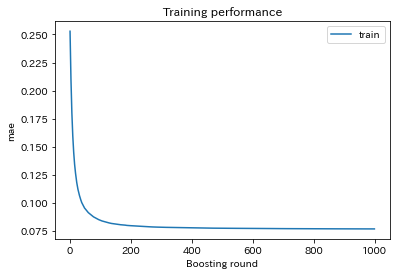

In [67]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['l1'], label='train')
plt.ylabel('mae')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
#plt.savefig('cv_logloss.jpg')
plt.show()

In [68]:
#提出用データ作業
df_test = pd.read_csv("../../data/test.csv", index_col=0)
df_test = df_pre.data_pre(df_test)
df_test = df_test.drop(columns="取引価格（総額）_log", axis=1)

#結果格納用のデータフレーム
df_pred_result = pd.DataFrame(index=[], columns=[1, 2, 3, 4, 5])
a=1
for model in models:
    predict = model.predict(df_test)
    df_pred_result[a] = predict
    a = a+1
df_test["取引価格（総額）_log"] = df_pred_result.mean(axis='columns').to_numpy()
df_test[["取引価格（総額）_log"]].to_csv("../../data/submit_test.csv")

test
